# **Optimization - Exercise 4 - Stochastic Gradient Descent**
---

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

As in previous exercises, we will train a linear regression model with one explanatory variable and an offset. The model is optimized under a least-squares loss. The variable $b$ contains the prediction targets (a vector of the same length of the dataset) and the variable $A$ is the data matrix, containing (1) a column of ones and (2) a column with the explanatory variable.

This time, the function to minimize is $f(x) = \frac{1}{n} \|Ax - b\|^2$ (we use the mean of the least squares to facilitate the convergence).

# Load the data

We will load again the [breast cancer dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset), using the first and third attributes (tumor mean radius and perimeter) as datapoints in two dimensions and trying to fit them on a line.

In [2]:
from sklearn.datasets import load_breast_cancer

def standardize(x):
    """Standardize the original data points (mean 0 and std dev 1)."""
    x = x - np.mean(x)
    x = x / np.std(x)
    return x

def build_model_data(x, y):
    """Get regression data in matrix form."""
    b = y
    num_samples = len(b)
    A = np.c_[np.ones(num_samples), x]
    return A, b

# Loads sklearn's Breast Cancer dataset
dataset = load_breast_cancer()

# Use as datapoints the first and third columns
radius = dataset.data[:,0]
perimeter = dataset.data[:,2]

A, b = build_model_data(standardize(radius), standardize(perimeter))

# Least Squares Estimation
Given an $ n \times d $ matrix $A$ and a $ n \times 1$ vector $b$, the goal is to find a vector $x \in \mathbb{R}^d$ which minimizes the objective function<br /><br /> $$f(x) = \frac{1}{n} \sum_{i=1}^{n} (w_i^\top x - b_i)^2 = \frac{1}{n} \|Ax - b\|^2 $$<br />

In this exercise, we will try to fit $x$ using Least Squares Estimation.

The function is $\mu$-strongly convex with $\mu = \lambda_{min}(\nabla^2 f(x)) = \frac{2}{n} \lambda_{min}(A^T A)$ and $L$-smooth with $L = \lambda_{max}(\nabla^2 f(x)) = \frac{2}{n} \lambda_{max}(A^T A)$, where $\lambda_{min}$ and $\lambda_{max}$ are the minimum and maximum of the eigenvalues.

When $A^{T} A$ is invertible, which is the case here, then we have a simple closed form solution for (the unique) $x^* = \text{argmin}_{x \in \mathbb{R}^d} f(x)$.

Indeed, solving $\nabla f(x^*) = 0$ leads to $x^* = (A^T A)^{-1} A^T b$. However, when $n$ and $d$ are big (which is the case in modern "big data" problems), using this formula is prohibitively expensive from a computational viewpoint, hence the necessity of using algorithms such as SGD, which consider a datapoint after the other.

In this lab, since $n$ and $d$ are small, and in order to exhibit the convergence rates, we start by computing $f(x^*)$.

In [3]:
def full_objective(A, x, b):
    """Compute the least squares objective over the whole dataset"""
    return np.mean((A.dot(x) - b)**2)

x_star = np.linalg.solve(A.T.dot(A), A.T.dot(b)) #solve A^TAx = A^Tb
best_objective = full_objective(A, x_star, b)
print("f(x*) = ", best_objective)

f(x*) =  0.004284837194907499



# Stochastic Gradient Descent Implementation

We recall the basic implementation of SGD:<br /><br />

1. sample $i \in [n]$ uniformly at random
2. $x_{t+1} := x_t − \gamma_t \nabla f_i (x_t)$<br /><br />

This update is almost identical to the classical gradient method, the
only difference being that we have computed the gradient not of the entire $f$ but only of one particular (randomly chosen) function $f_i$.

Instead of using a single element $f_i$, the actual implementation will use an average of several of them:<br /><br />

$\tilde{g}_t := \frac{1}{m} \sum_{j=1}^{m} (g^j_t)$<br /><br />

where $g_t^j = \nabla f_{i_j} (x_t)$ for an index $i_j$ . The set of the (distinct) $i_j$ indices is called a *mini-batch*, and $m$ is the mini batch size. With $m = 1$ we reobtain the SGD as defined before, while with $m = n$ we obtain the full gradient descent.

Now you can fill in the function `minibatch_gradient` below:

In [4]:
def minibatch_gradient(A, x, b):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.

    :param b: a numpy array of shape (num_examples)
    :param A: a numpy array of shape (num_examples, num_features)
    :param x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)

    :return: gradient: numpy array of shape (num_features)
    """
    # ***************************************************
    # YOUR CODE HERE

    batch_size = len(b)
    Axmb = A.dot(x) - b
    gradient = 2*A.T.dot(Axmb) / batch_size

    # TODO: implement gradient computation.
    # ***************************************************

    return gradient

You should also verify empirically for a fixed parameter vector $x$ that the expected value of your `minibatch_gradient` function equals the full gradient. Validating this property for a mini-batch of size 1 is sufficient.

To check that two arrays are element-wise equal within a tolerance we can use `np.allclose`. The `assert` instruction will raise an error if the condition is not verified.

In [5]:
num_trials = 10
for i in range(num_trials):
    # Try different parameter vectors $x$
    x = np.random.rand(A.shape[1])

    stochastic_gradients = []
    # *********************************************************
    # YOUR CODE HERE
    # TODO: Compute all stochastic gradients, mini-batch size 1

    for i in range(len(b)):
        stochastic_gradients.append(minibatch_gradient(A[i:i+1, :], x, b[i:i+1]))

    # *********************************************************

    # axis = 0 is the mean along the column
    mean_stochastic_gradients = np.mean(stochastic_gradients, axis = 0)

    # *********************************************************
    # YOUR CODE HERE

    full_gradient = minibatch_gradient(A, x, b)

    # *********************************************************

    # Those should be the same on average
    assert np.allclose(mean_stochastic_gradients, full_gradient)

print('Tests passed')

Tests passed


In [6]:
def stochastic_gradient(A, x, b, batch_size=1):
    """Compute a stochastic gradient"""
    dataset_size = len(b)
    indices = np.random.choice(dataset_size, batch_size, replace=False)
    return minibatch_gradient(A[indices, :], x, b[indices])

def stochastic_gradient_descent(
        data_A,
        initial_x,
        targets_b,
        batch_size,
        epochs,
        learning_rate,
        decreasing_learning_rate=False):
    """
    Mini-batch Stochastic Gradient Descent for Linear Least Squares problems.

    :param data_A: numpy array of size (num_examples, num_features)
    :param initial_x: starting parameters, a numpy array of size (num_features)
    :param targets_b: numpy array of size (num_examples)
    :param batch_size: size of the mini-batches
    :param max_iters: integer, number of updates to do
    :param learning_rate: float
    :param decreasing_learning_rate: if true, the learning rate should decay as 1 / t

    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - xs, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update
    x = initial_x
    objectives = [full_objective(data_A, x, targets_b)]  # list of the loss values after each update

    # ***************************************************
    # YOUR CODE HERE
    # TODO: implement stochastic gradient descent.

    total_iterations = 0

    print("SGD({bi:d}/{ti:d}): objective = {l:f}, total number of iterations = {ii:d}".format(
                  bi=0, ti=epochs, l=full_objective(data_A, x, targets_b), ii=total_iterations))

    for epoch in range(epochs):

      if (len(targets_b)/batch_size) != int(len(targets_b)/batch_size):
        num_iter = int(len(targets_b)/batch_size) + 1
      else:
        num_iter = int(len(targets_b)/batch_size)

      for iteration in range(num_iter):

         grad = stochastic_gradient(data_A, x, targets_b, batch_size=batch_size)

         if decreasing_learning_rate:
             gamma = learning_rate / (total_iterations + 1)
         else:
             gamma = learning_rate

         # update x through the stochastic gradient update
         x = x - gamma * grad

         total_iterations = total_iterations + 1

         # store x and objective
         xs.append(x.copy())
         objective = full_objective(data_A, x, targets_b)
         objectives.append(objective)

      print("SGD({bi:d}/{ti:d}): objective = {l:f}, total number of iterations = {ii:d}".format(
                  bi=epoch + 1, ti=epochs, l=objective, ii=total_iterations))
    # ***************************************************
    return objectives, xs

## Naive test

Now it is time to test your optimizer with a naive step size with the example code below.

In [7]:
import datetime

# Define the parameters of the algorithm.
max_iters = 10 # epochs
gamma = 0.2   # this is totally arbitrary
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(A, x_initial, b, batch_size, max_iters, gamma, False)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0/10): objective = 1.000000, total number of iterations = 0
SGD(1/10): objective = 0.010401, total number of iterations = 569
SGD(2/10): objective = 0.004811, total number of iterations = 1138
SGD(3/10): objective = 0.006112, total number of iterations = 1707
SGD(4/10): objective = 0.015342, total number of iterations = 2276
SGD(5/10): objective = 0.009561, total number of iterations = 2845
SGD(6/10): objective = 0.012350, total number of iterations = 3414
SGD(7/10): objective = 0.010043, total number of iterations = 3983
SGD(8/10): objective = 0.013764, total number of iterations = 4552
SGD(9/10): objective = 0.007245, total number of iterations = 5121
SGD(10/10): objective = 0.016071, total number of iterations = 5690
SGD: execution time=0.343 seconds


## Plotting the convergence

As usual, using an arbitrary constant step size does not lead to appropriate convergence: the iterates "saturate" because of the stochastic noise and stop making progress at some point. We thus need to use more appropriate step sizes with guarantee of convergence.

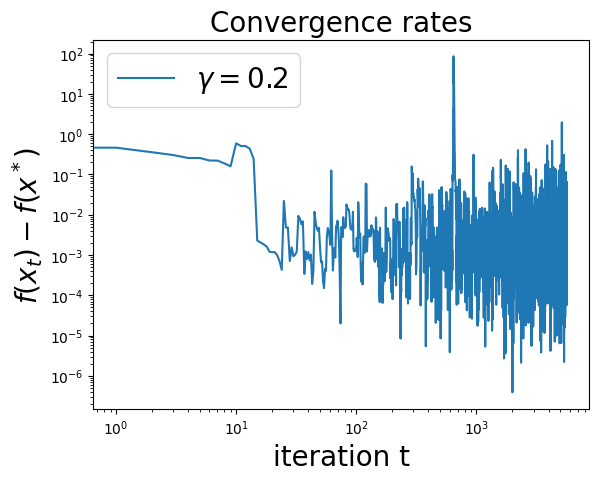

In [8]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.2$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

## Assuming bounded expected stochastic gradients
Assume we are moving in a bounded region $\|x\| \leq R$ containing all iterates (and we assume $\|x_0-x^\star\| \leq R$ as well, for simplicity). As in the previous exercise, we consider $R = 25$.

Then by $\nabla f(x) = \frac{2}{n} A^\top (Ax - b)$, it can be proven that $f$ is Lipschitz over that bounded region, with Lipschitz constant $\|\nabla f(x)\| \leq \frac{2}{n} (\|A^\top A\|\|x\| + \|A^\top b\|)$.

We also know that $E\big[\|g_t\|\big | x_t\big]\ = \nabla f(x)$. So to find B such that  $E\big[\|g_t\|^2\big]\leq B^2$, we need to compute the Lipschitz constant.

In [9]:
# Define the parameters of the algorithm.
epochs = 10
R = 25
batch_size = 1

# ***************************************************
# YOUR CODE HERE
# TODO: Compute a better learning rate

B = (2/len(A)) * (R*np.linalg.norm(np.dot(A.T,A)) + np.linalg.norm(np.dot(A.T,b)))
gamma = R/(B*np.sqrt(epochs*len(b)/batch_size))

# ***************************************************

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(A, x_initial, b, batch_size, epochs, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))


SGD(0/10): objective = 1.000000, total number of iterations = 0
SGD(1/10): objective = 0.004414, total number of iterations = 569
SGD(2/10): objective = 0.004433, total number of iterations = 1138
SGD(3/10): objective = 0.004291, total number of iterations = 1707
SGD(4/10): objective = 0.004292, total number of iterations = 2276
SGD(5/10): objective = 0.004300, total number of iterations = 2845
SGD(6/10): objective = 0.004301, total number of iterations = 3414
SGD(7/10): objective = 0.004356, total number of iterations = 3983
SGD(8/10): objective = 0.004294, total number of iterations = 4552
SGD(9/10): objective = 0.004479, total number of iterations = 5121
SGD(10/10): objective = 0.004317, total number of iterations = 5690
SGD: execution time=0.617 seconds


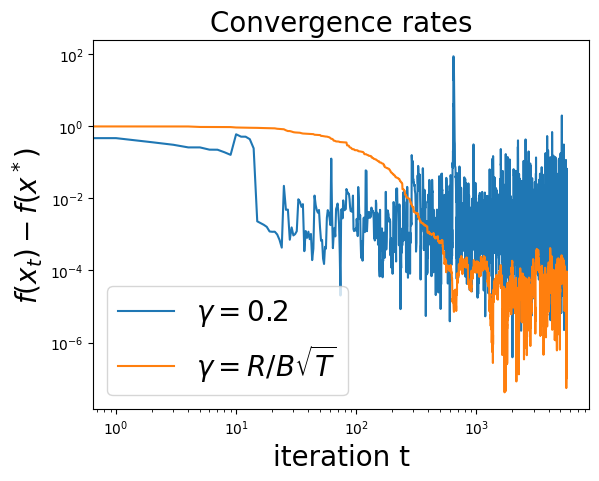

In [10]:
# Plot the convergence again
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.2$')
plt.loglog(sgd_objectives_dec_gamma - best_objective, label = r'$\gamma = R / B \sqrt{T}$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

## SGD using strong convexity
Now try doing SGD with a better learning rate using the fact that the objective function is $\mu$-strongly convex. We recall that in this case, the learning rate to use is $\gamma_t = \frac{2}{\mu(t+1)}$, and it decays over each iteration. So we can start using the SGD function with a decreasing learning rate:

In [11]:
# Define the parameters of the algorithm.
max_iters = 10

# ***************************************************
# YOUR CODE HERE
# TODO: find mu

eig = np.linalg.eigvals(A.T.dot(A))
mu = 2 * min(eig)/(len(b))

# ***************************************************

gamma0 = 2 / mu
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma_mu, sgd_xs_dec_gamma_mu = stochastic_gradient_descent(
    A, x_initial, b, batch_size, max_iters, gamma0, decreasing_learning_rate=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0/10): objective = 1.000000, total number of iterations = 0
SGD(1/10): objective = 0.004309, total number of iterations = 569
SGD(2/10): objective = 0.004287, total number of iterations = 1138
SGD(3/10): objective = 0.004285, total number of iterations = 1707
SGD(4/10): objective = 0.004286, total number of iterations = 2276
SGD(5/10): objective = 0.004285, total number of iterations = 2845
SGD(6/10): objective = 0.004288, total number of iterations = 3414
SGD(7/10): objective = 0.004289, total number of iterations = 3983
SGD(8/10): objective = 0.004296, total number of iterations = 4552
SGD(9/10): objective = 0.004287, total number of iterations = 5121
SGD(10/10): objective = 0.004286, total number of iterations = 5690
SGD: execution time=0.340 seconds


## Convergence comparison


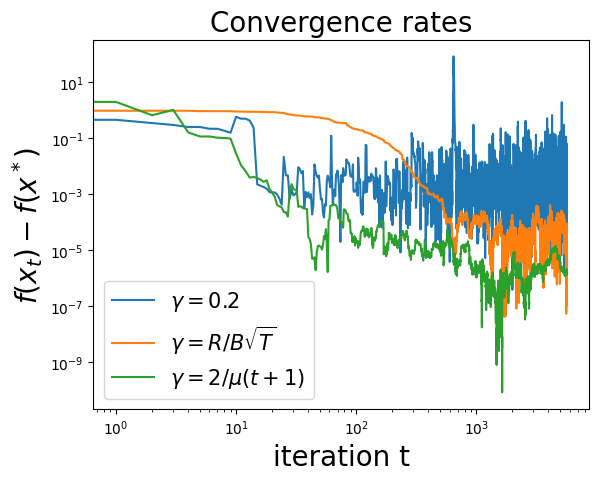

In [12]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.2$')
plt.loglog(sgd_objectives_dec_gamma - best_objective, label = r'$\gamma = R / B \sqrt{T}$')
plt.loglog(sgd_objectives_dec_gamma_mu - best_objective, label = r'$\gamma = 2 / \mu (t + 1)$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

You can test the SGD code over more complicated dataset, and verify the relative speedup compared to the vanilla gradient descent.

 # Using all the features in a dataset

In [16]:
from sklearn.datasets import load_diabetes

dataset = load_diabetes()

features = dataset.data
output = dataset.target # diabetes progression

A, b = build_model_data(standardize(features), standardize(output))

In [17]:
print('Number of samples n = ', b.shape[0])
print('Dimension of each sample d = ', A.shape[1])

Number of samples n =  442
Dimension of each sample d =  11


## Stochastic Gradient Descent

### Running SGD with minibatch:

In [18]:
max_iters = 100
x_initial = np.zeros(A.shape[1])
batch_size = 32
gamma = 0.001

SGD_objective, SGD_xs = stochastic_gradient_descent(A, x_initial, b, batch_size, max_iters, gamma)


SGD(0/100): objective = 1.000000, total number of iterations = 0
SGD(1/100): objective = 0.927529, total number of iterations = 14
SGD(2/100): objective = 0.868470, total number of iterations = 28
SGD(3/100): objective = 0.817135, total number of iterations = 42
SGD(4/100): objective = 0.777492, total number of iterations = 56
SGD(5/100): objective = 0.737297, total number of iterations = 70
SGD(6/100): objective = 0.708314, total number of iterations = 84
SGD(7/100): objective = 0.686889, total number of iterations = 98
SGD(8/100): objective = 0.667417, total number of iterations = 112
SGD(9/100): objective = 0.648689, total number of iterations = 126
SGD(10/100): objective = 0.634840, total number of iterations = 140
SGD(11/100): objective = 0.621413, total number of iterations = 154
SGD(12/100): objective = 0.610123, total number of iterations = 168
SGD(13/100): objective = 0.600490, total number of iterations = 182
SGD(14/100): objective = 0.589963, total number of iterations = 196

## AdaGrad

AdaGrad (Adaptive Gradient Algorithm) is an adaptive variant of Stochastic Gradient Descent.
The Algorithm is build as follows:<br />
initialize $x$ arbitrary and choose a $\gamma > 0$.

Pick a mini-batch stochastic gradient $\tilde{g}_t$ uniformly at random, then update<br /><br />

$[G_t]_i := \sum_{s=0}^{t} [\tilde{g}_s]_i^2 $<br /><br />
$[x_{t+1}]_i := [x_t]_i - \frac{\gamma}{\sqrt{[G_t]_i}} [\tilde{g}_t]_i $<br /><br />

for each $i$.


### AdaGrad definition

In [19]:
def ADAGRAD(A, initial_x, b, batch_size, epochs, gamma):

    xs = [initial_x]
    x = initial_x
    objectives = [full_objective(A, x, b)]
    sizes = A.shape
    n_regressors = sizes[1]
    G = np.zeros(n_regressors)

    total_iterations = 0

    print("ADAGRAD({bi:d}/{ti:d}): objective = {l:f}, total number of iterations = {ii:d}".format(
                  bi=0, ti=epochs, l=full_objective(A, x, b), ii=total_iterations))

    for epoch in range(epochs):

      if (len(b)/batch_size) != int(len(b)/batch_size):
        num_iter = int(len(b)/batch_size) + 1
      else:
        num_iter = int(len(b)/batch_size)

      for iteration in range(num_iter):

         grad = stochastic_gradient(A, x, b, batch_size=batch_size)

         G = G + np.diag(grad**2)
         G = np.sqrt(G)
         Ginv = np.linalg.inv(G)
         x = x - gamma*Ginv.dot(grad)

         total_iterations = total_iterations + 1
         # store x and objective
         xs.append(x.copy())
         objective = full_objective(A, x, b)
         objectives.append(objective)

      print("ADAGRAD({bi:d}/{ti:d}): objective = {l:f}, total number of iterations = {ii:d}".format(
                  bi=epoch + 1, ti=epochs, l=objective, ii=total_iterations))

    return objectives, xs


### Running ADAGRAD:

In [20]:
init_x = np.zeros(A.shape[1])
max_iters = 100
batch_size = 32

gamma = 0.001

ADAGRAD_objective, ADAGRAD_xs = ADAGRAD(A, init_x, b, batch_size, max_iters, gamma)

ADAGRAD(0/100): objective = 1.000000, total number of iterations = 0
ADAGRAD(1/100): objective = 0.948462, total number of iterations = 14
ADAGRAD(2/100): objective = 0.904461, total number of iterations = 28
ADAGRAD(3/100): objective = 0.866822, total number of iterations = 42
ADAGRAD(4/100): objective = 0.833088, total number of iterations = 56
ADAGRAD(5/100): objective = 0.801584, total number of iterations = 70
ADAGRAD(6/100): objective = 0.775828, total number of iterations = 84
ADAGRAD(7/100): objective = 0.749334, total number of iterations = 98
ADAGRAD(8/100): objective = 0.727822, total number of iterations = 112
ADAGRAD(9/100): objective = 0.709694, total number of iterations = 126
ADAGRAD(10/100): objective = 0.690457, total number of iterations = 140
ADAGRAD(11/100): objective = 0.673446, total number of iterations = 154
ADAGRAD(12/100): objective = 0.658920, total number of iterations = 168
ADAGRAD(13/100): objective = 0.647918, total number of iterations = 182
ADAGRAD(14/

## ADAM

Adam (Adaptive Moment Estimation) is a momentum variant of Adagrad.
The Algorithm is build as follows:<br />
initialize $x$ arbitrary and choose a $\gamma > 0$.

Pick a mini-batch stochastic gradient $\tilde{g}_t$ uniformly at random, then update<br /><br />

$[m_t]_i := b_1[m_{t-1}]_i + (1-b_1)[\tilde{g}_t]_i $<br /><br />
$[v_t]_i := b_2[v_{t-1}]_i + (1-b_2)[\tilde{g}_t]_i^2 $<br /><br />
$[x_{t+1}]_i := [x_t]_i - \frac{\gamma}{\sqrt{[v_t]_i}} [m_t]_i $<br /><br />

for each $i$.<br />
Common values of $b_1$ and $b_2$ are $0.9$ and $0.999$, respectively.

### ADAM definition

In [21]:
def ADAM(A, initial_x, b, batch_size, epochs, gamma, beta1, beta2):

    xs = [initial_x]
    x = initial_x
    objectives = [full_objective(A, x, b)]

    m = initial_x
    v = initial_x

    total_iterations = 0

    print("ADAM({bi:d}/{ti:d}): objective = {l:f}, total number of iterations = {ii:d}".format(
                  bi=0, ti=epochs, l=full_objective(A, x, b), ii=total_iterations))

    for epoch in range(epochs):

      if (len(b)/batch_size) != int(len(b)/batch_size):
        num_iter = int(len(b)/batch_size) + 1
      else:
        num_iter = int(len(b)/batch_size)

      for iteration in range(num_iter):

         grad = stochastic_gradient(A, x, b, batch_size=batch_size)

         m = beta1*m + (1-beta1)*grad
         v = beta2*v + (1-beta2)*grad**2
         v_diag = np.diag(v)
         rad_v = np.sqrt(v_diag)
         vinv = np.linalg.inv(rad_v)
         x = x - gamma*vinv.dot(m)

         total_iterations = total_iterations + 1
         # store x and objective
         xs.append(x.copy())
         objective = full_objective(A, x, b)
         objectives.append(objective)

      print("ADAM({bi:d}/{ti:d}): objective = {l:f}, total number of iterations = {ii:d}".format(
                  bi=epoch + 1, ti=epochs, l=objective, ii=total_iterations))

    return objectives, xs



### Running ADAM:

In [22]:
init_x = np.zeros(A.shape[1])
max_iters = 100
batch_size = 32

gamma = 0.001
beta1 = 0.9
beta2 = 0.999
# values of gamma, beta1, beta2 commonly used, for example by keras

ADAM_objective, ADAM_xs = ADAM(A, init_x, b, batch_size, max_iters, gamma, beta1, beta2)

ADAM(0/100): objective = 1.000000, total number of iterations = 0
ADAM(1/100): objective = 0.672712, total number of iterations = 14
ADAM(2/100): objective = 0.576405, total number of iterations = 28
ADAM(3/100): objective = 0.538587, total number of iterations = 42
ADAM(4/100): objective = 0.514444, total number of iterations = 56
ADAM(5/100): objective = 0.504764, total number of iterations = 70
ADAM(6/100): objective = 0.499097, total number of iterations = 84
ADAM(7/100): objective = 0.495654, total number of iterations = 98
ADAM(8/100): objective = 0.495593, total number of iterations = 112
ADAM(9/100): objective = 0.491989, total number of iterations = 126
ADAM(10/100): objective = 0.490585, total number of iterations = 140
ADAM(11/100): objective = 0.489791, total number of iterations = 154
ADAM(12/100): objective = 0.488693, total number of iterations = 168
ADAM(13/100): objective = 0.488685, total number of iterations = 182
ADAM(14/100): objective = 0.488506, total number of i

### PLOT: Minibatch Gradient Descent + ADAGRAD + ADAM

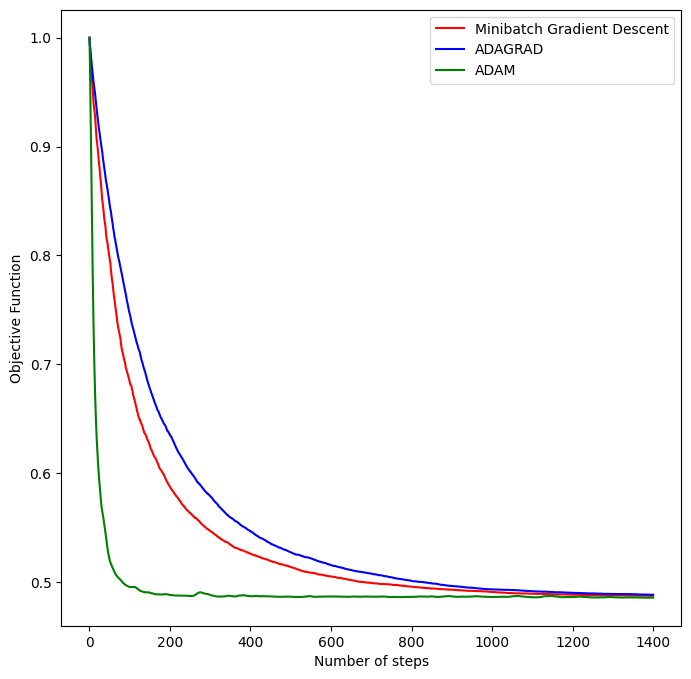

In [23]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')

plt.plot(range(len(SGD_objective)), SGD_objective,'red', label='Minibatch Gradient Descent')
plt.plot(range(len(ADAGRAD_objective)), ADAGRAD_objective,'blue', label='ADAGRAD')
plt.plot(range(len(ADAM_objective)), ADAM_objective,'green', label='ADAM')
plt.legend(loc='upper right')
plt.show()